In [1]:
data_dir = '/mnt/c/Users/ferna/Desktop/SingleCell/data/'
%run -i '../../utils/load_data.py'

# import sys
# sys.path.insert(0, '../../utils/')
import importlib
# importlib.reload(scp)
# importlib.reload(spu)
# sns.reset_orig()
from scipy.stats import chisquare
from scipy.stats import combine_pvalues
%run -i '../../utils/test_functions.py'

import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances

# def get_signature_score(PSI_tab, exon):
#     exon_score = (PSI_tab.loc[exon] - PSI_tab.mean())/(PSI_tab.std())
#     return exon_score.dropna()

def get_auto_correlation(exon_score, pca):
    N = len(exon_score)
    weights = euclidean_distances(pca.loc[exon_score.index][['PC1', 'PC2']])
    W = weights.sum().sum()
    
def get_signature_score(PSI_tab, exon):
    exon_score = (PSI_tab.loc[exon] - PSI_tab.mean())/(PSI_tab.std())
    return exon_score.dropna()


def get_distance_matrix(pca, k=10):
    nbrs = NearestNeighbors(n_neighbors=k).fit(pca[['PC1', 'PC2']])
    distances, indices = nbrs.kneighbors(pca[['PC1', 'PC2']])
    
    cells = list(pca.index)
    
    W = pd.DataFrame(np.zeros((len(cells), len(cells))))
    W.columns = cells
    W.index = cells
    
    for i in tqdm(range(len(cells))):
        cell_i = cells[i]
        sigma = np.max(distances[i])
        for j in range(len(distances[i])):
            
            cell_j = cells[indices[i][j]]
            
            d = distances[i][j]
#             w = np.exp(-(d**2)/(sigma**2))
            w = np.exp(-(d**2)/(sigma))
            
            W.loc[cell_i, cell_j] = w
    
    
    
    return W
    
def get_C(PSI_tab, W, exon):
    obs_cells = PSI_tab.loc[exon].dropna().index
    x = (PSI_tab.loc[exon, obs_cells].values.reshape(-1, 1) - PSI_tab.loc[exon, obs_cells].values.reshape(1, -1))
    w = W.loc[obs_cells, obs_cells]
    num = (len(obs_cells)-1)*((w*(x**2)).sum().sum())
    den = (2*w.sum().sum())*np.sum((PSI_tab.loc[exon, obs_cells] - PSI_tab.loc[exon, obs_cells].mean())**2)
    C = num/den
    score = 1 - C
    return score

def get_C_set(PSI_tab, W, exon_list):
    obs_cells = PSI_tab.loc[exon].dropna().index
    x = (PSI_tab.loc[exon, obs_cells].values.reshape(-1, 1) - PSI_tab.loc[exon, obs_cells].values.reshape(1, -1))
    w = W.loc[obs_cells, obs_cells]
    num = (len(obs_cells)-1)*((w*(x**2)).sum().sum())
    den = (2*w.sum().sum())*np.sum((PSI_tab.loc[exon, obs_cells] - PSI_tab.loc[exon, obs_cells].mean())**2)
    C = num/den
    score = 1 - C
    return score

In [3]:
chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI, chen_mrna_counts, 0.05)
chen_int_exons = [x for x in chen_int_exons if x in mrna_per_event_chen.index]
chen_filtered_lax = filter_psi(chen_PSI, chen_int_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'], 
                           chen_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

chen_filtered_lax_reads = filter_psi(chen_PSI, chen_int_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'], 
                           chen_read_counts, mrna_min=0, reads_min=10, cell_min=0.05)

song_int_genes, song_int_exons = spu.get_int_events(song_PSI, song_mrna_counts, 0.05)
song_int_exons = [x for x in song_int_exons if x in mrna_per_event_song.index]
song_filtered_lax = filter_psi(song_PSI, song_int_exons, mrna_per_event_song, song_coverage_tab['SJ_coverage'], 
                           song_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

song_filtered_lax_reads = filter_psi(song_PSI, song_int_exons, mrna_per_event_song, song_coverage_tab['SJ_coverage'], 
                           song_read_counts, mrna_min=0, reads_min=10, cell_min=0.05)

trapnell_int_genes, trapnell_int_exons = spu.get_int_events(trapnell_PSI, trapnell_mrna_counts, 0.05)
trapnell_int_exons = [x for x in trapnell_int_exons if x in mrna_per_event_trapnell.index]
trapnell_filtered_lax = filter_psi(trapnell_PSI, trapnell_int_exons, mrna_per_event_trapnell, trapnell_coverage_tab['SJ_coverage'], 
                           trapnell_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

trapnell_filtered_lax_reads = filter_psi(trapnell_PSI, trapnell_int_exons, mrna_per_event_trapnell, trapnell_coverage_tab['SJ_coverage'], 
                           trapnell_read_counts, mrna_min=0, reads_min=10, cell_min=0.05)

lescroart_int_genes, lescroart_int_exons = spu.get_int_events(lescroart_PSI, lescroart_mrna_counts, 0.05)
lescroart_int_exons = [x for x in lescroart_int_exons if x in mrna_per_event_lescroart.index]
lescroart_filtered_lax = filter_psi(lescroart_PSI, lescroart_int_exons, mrna_per_event_lescroart, lescroart_coverage_tab['SJ_coverage'], 
                           lescroart_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

lescroart_filtered_lax_reads = filter_psi(lescroart_PSI, lescroart_int_exons, mrna_per_event_lescroart, lescroart_coverage_tab['SJ_coverage'], 
                           lescroart_read_counts, mrna_min=0, reads_min=10, cell_min=0.05)

In [4]:
# Ws = get_distance_matrix(chen_pca_clust, 488)
# figsize(15, 15)
# sns.heatmap(Ws.loc[chen_pca_clust.pseudotime.sort_values().index, 
#                       chen_pca_clust.pseudotime.sort_values().index],cmap=cm.bone_r)
# plt.show()

HBox(children=(IntProgress(value=0, max=488), HTML(value='')))

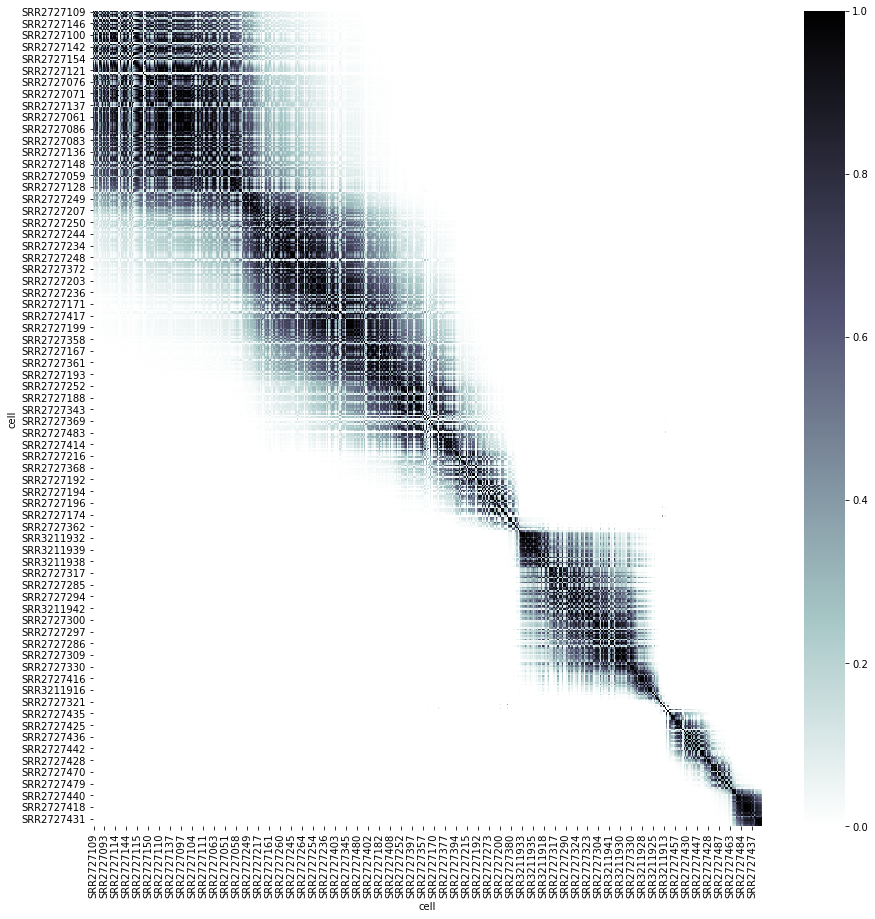

In [5]:
Ws = get_distance_matrix(chen_pca_clust, 488)
figsize(15, 15)
sns.heatmap(Ws.loc[chen_pca_clust.pseudotime.sort_values().index, 
                      chen_pca_clust.pseudotime.sort_values().index],cmap=cm.bone_r)
plt.show()

In [ ]:
# Ws = get_distance_matrix(chen_pca_clust, 488)
import time as t
# figsize(15, 15)
# sns.heatmap(Ws.loc[chen_pca_clust.pseudotime.sort_values().index, 
#                       chen_pca_clust.pseudotime.sort_values().index],cmap=cm.bone_r)
# plt.show()
# chen_iqr = chen_PSI.quantile(0.75, axis=1) - chen_PSI.quantile(0.25, axis=1)
chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI, chen_mrna_counts, 0.05)
# chen_int_exons = [x for x in chen_iqr.index[chen_iqr >= 0.25] if x in mrna_per_event_chen.index]
observed_exons = chen_PSI.index[chen_PSI.isna().mean(axis=1) <= 0.5]
test_exons = [x for x in observed_exons if x in chen_int_exons]

exon_list = []
C_scores = []
for exon in tqdm(test_exons):
    exon_score = get_C(chen_PSI, Ws, exon)
    if exon_score >= 0:
        C_scores.append(exon_score)
        exon_list.append(exon)
        for i in range(10):
            scramble_cells = r.choice(chen_PSI.columns, 488, replace=False)
            mock_PSI = chen_PSI[scramble_cells]
            mock_PSI.columns = chen_PSI.columns
            mock_score = get_C(mock_PSI, Ws, exon)
            if mock_score >= 0:
                C_scores.append(mock_PSI)
                exon_list.append('mock_'+exon+'_'+str(i))
    
pvals = pd.DataFrame()
pvals['C_score'] = C_scores
pvals.index = exon_list




figsize(6, 5)
selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.5] if x in pvals.index]
# for exon in pvals.index[pvals.C_score >= pvals.C_score.quantile(0.99)]:
#     plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c=chen_PSI.loc[exon], cmap=cm.viridis)
#     plt.title(exon)
#     plt.show()
    
print('bad')

# for exon in pvals.index[pvals.C_score <= pvals.C_score.quantile(0.01)]:
#     plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c=chen_PSI.loc[exon], vmin=0, vmax=1, cmap=cm.viridis)
#     plt.title(exon)
#     plt.show()
    
    
plt.hist(pvals.loc[selected_mrna, 'C_score'], alpha=0.5, density=True)
plt.hist(pvals.C_score, alpha=0.5, density=True)

HBox(children=(IntProgress(value=0, max=1176), HTML(value='')))